 **Optimizer & Activation Function Benchmarking for Regression (PyTorch)
Project Overview**

This project demonstrates a systematic comparison of different optimizers and activation functions for a regression task using PyTorch.

 The goal is to understand how architectural and optimization choices affect model performance on unseen data.

A simple MLP regressor is trained on the California Housing dataset, and performance is evaluated using RMSE and R² on a held-out test set.

**What This Project Covers**


*   Public regression dataset (California Housing)
*   Feature normalization and clean train/validation/test splits
*   Modular PyTorch model design
*   Experimentation across:

**Optimizers:** SGD, Adam, RMSprop, AdamW

**Activations:** ReLU, Tanh, GELU, LeakyReLU

**Early stopping for fair comparison**

Visualization of test performance and learning curves

## 1. Setup and Reproducibility

This cell imports all required libraries and sets random seeds to ensure
reproducible results across runs. Reproducibility is critical when comparing
optimizers and activation functions so that differences in results are due to
model choices rather than randomness.

The code also detects whether a GPU is available and configures PyTorch
accordingly for faster training in Google Colab.


In [ ]:
# ============================================================
# Cell 1: Imports + Reproducibility
# - Sets random seeds for repeatable runs
# - Imports libraries used across the notebook
# ============================================================

import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For determinism (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 2. Load California Housing Dataset

In this project, we use the California Housing dataset, a widely used public
dataset for regression tasks. The target variable represents median house
values, while the features capture demographic and geographic information.

The dataset is split into training, validation, and test sets to ensure
unbiased evaluation of model performance.


In [ ]:
# ============================================================
# Cell 2: Load a public regression dataset
# - California Housing dataset (public, widely used)
# - Creates train/val/test split
# ============================================================

data = fetch_california_housing()
X = data.data.astype(np.float32)
y = data.target.astype(np.float32).reshape(-1, 1)

# Split into train+temp and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1765, random_state=42
)
# (0.1765 of 0.85 ≈ 0.15) => ~70/15/15 total split

X_train.shape, X_val.shape, X_test.shape


((14447, 8), (3097, 8), (3096, 8))

## 3. Feature Scaling and Data Preparation

Neural networks are sensitive to feature scale, so we standardize input
features using `StandardScaler`. The scaler is fit only on the training set
to avoid data leakage.

The data is then converted into PyTorch tensors and wrapped into
DataLoaders for efficient mini-batch training and evaluation.


In [ ]:
# ============================================================
# Cell 3: Standardize features
# - StandardScaler fitted only on train
# - Applies transform to val/test
# - Target scaling is optional; here we keep y in original units
# ============================================================

x_scaler = StandardScaler()
X_train_s = x_scaler.fit_transform(X_train).astype(np.float32)
X_val_s   = x_scaler.transform(X_val).astype(np.float32)
X_test_s  = x_scaler.transform(X_test).astype(np.float32)

# Convert to torch tensors
X_train_t = torch.from_numpy(X_train_s)
y_train_t = torch.from_numpy(y_train)

X_val_t = torch.from_numpy(X_val_s)
y_val_t = torch.from_numpy(y_val)

X_test_t = torch.from_numpy(X_test_s)
y_test_t = torch.from_numpy(y_test)

# DataLoaders
batch_size = 256
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

X_train_t.shape, y_train_t.shape


(torch.Size([14447, 8]), torch.Size([14447, 1]))

## 4. MLP Regressor with Configurable Activation Functions

This cell defines a simple Multi-Layer Perceptron (MLP) for regression.
The architecture is intentionally kept lightweight to focus on the
impact of optimizer and activation choices.

A model factory pattern is used so that different activation functions
can be swapped in easily without changing the rest of the code.


In [ ]:
# ============================================================
# Cell 4: Model definition
# - Simple MLP for regression
# - Activation function is configurable (ReLU/Tanh/GELU/LeakyReLU, etc.)
# ============================================================

class MLPRegressor(nn.Module):
    def __init__(self, in_features: int, activation: nn.Module, hidden_sizes=(128, 64), dropout=0.0):
        super().__init__()
        layers = []
        prev = in_features

        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(activation)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h

        layers.append(nn.Linear(prev, 1))  # regression output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def make_activation(name: str) -> nn.Module:
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "tanh":
        return nn.Tanh()
    if name == "gelu":
        return nn.GELU()
    if name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.1)
    raise ValueError(f"Unknown activation: {name}")


## 5. Training and Evaluation Utilities

This section contains reusable functions for:
- Training the model for one epoch
- Evaluating validation loss
- Generating predictions on test data
- Computing regression metrics (RMSE and R²)

Using shared utilities ensures consistency across all experiments.


In [ ]:
# ============================================================
# Cell 5: Training & Evaluation Utilities
# - Uses MSE loss for training
# - Reports RMSE and R² (higher is better for R², lower is better for RMSE)
# ============================================================

def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    n = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)

    return total_loss / n

@torch.no_grad()
def eval_loss(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    n = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        preds = model(xb)
        loss = loss_fn(preds, yb)

        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)

    return total_loss / n

@torch.no_grad()
def predict_numpy(model, loader):
    model.eval()
    preds_all = []
    y_all = []

    for xb, yb in loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        preds_all.append(preds)
        y_all.append(yb.numpy())

    return np.vstack(preds_all).reshape(-1), np.vstack(y_all).reshape(-1)

def metrics_rmse_r2(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2


## 6. Experiment Runner with Early Stopping

This cell defines the core experiment loop. For each combination of
optimizer and activation function, the model is trained with early
stopping based on validation loss.

Early stopping prevents overfitting and ensures fair comparison by
selecting the best-performing model checkpoint.


In [ ]:
# ============================================================
# Cell 6: Experiment Runner
# - Trains models for each (optimizer, activation)
# - Uses early stopping on validation loss for fairness and speed
# ============================================================

def make_optimizer(name: str, params, lr: float):
    name = name.lower()
    if name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=0.9)
    if name == "adam":
        return torch.optim.Adam(params, lr=lr)
    if name == "rmsprop":
        return torch.optim.RMSprop(params, lr=lr)
    if name == "adamw":
        return torch.optim.AdamW(params, lr=lr, weight_decay=1e-2)
    raise ValueError(f"Unknown optimizer: {name}")

def run_experiment(activation_name: str, optimizer_name: str, lr: float = 1e-3,
                   epochs: int = 60, patience: int = 10):
    set_seed(42)  # keep each run comparable

    act = make_activation(activation_name)
    model = MLPRegressor(in_features=X_train_t.shape[1], activation=act, hidden_sizes=(128, 64), dropout=0.0).to(device)

    optimizer = make_optimizer(optimizer_name, model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    no_improve = 0

    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        va_loss = eval_loss(model, val_loader, loss_fn)

        train_losses.append(tr_loss)
        val_losses.append(va_loss)

        # Early stopping logic
        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    # Test metrics
    y_pred, y_true = predict_numpy(model, test_loader)
    rmse, r2 = metrics_rmse_r2(y_true, y_pred)

    return {
        "activation": activation_name,
        "optimizer": optimizer_name,
        "lr": lr,
        "best_val_mse": best_val,
        "test_rmse": rmse,
        "test_r2": r2,
        "train_curve": train_losses,
        "val_curve": val_losses
    }


## 7. Running the Experiment Grid

Here we iterate over all combinations of optimizers and activation
functions. Each configuration is trained independently, and final
performance metrics are collected.

This design makes it easy to extend the grid with additional optimizers,
activations, or learning rates.


In [ ]:
# ============================================================
# Cell 7: Run experiments
# - Keep the grid small so it runs fast in Colab
# - You can expand the list or tune lrs per optimizer
# ============================================================

activations = ["ReLU", "Tanh", "GELU", "LeakyReLU"]
optimizers  = ["SGD", "Adam", "RMSprop", "AdamW"]

# You can tweak LR values if you want more fairness per optimizer.
# For simplicity, we keep the same LR across runs.
lr = 1e-3

results = []
for act in activations:
    for opt in optimizers:
        out = run_experiment(act, opt, lr=lr, epochs=60, patience=10)
        results.append(out)
        print(f"Done: act={act:9s} opt={opt:7s}  RMSE={out['test_rmse']:.4f}  R2={out['test_r2']:.4f}")


Done: act=ReLU      opt=SGD      RMSE=0.6055  R2=0.7203
Done: act=ReLU      opt=Adam     RMSE=0.5343  R2=0.7821
Done: act=ReLU      opt=RMSprop  RMSE=0.5274  R2=0.7877
Done: act=ReLU      opt=AdamW    RMSE=0.5341  R2=0.7824
Done: act=Tanh      opt=SGD      RMSE=0.6524  R2=0.6752
Done: act=Tanh      opt=Adam     RMSE=0.5436  R2=0.7745
Done: act=Tanh      opt=RMSprop  RMSE=0.5518  R2=0.7676
Done: act=Tanh      opt=AdamW    RMSE=0.5448  R2=0.7735
Done: act=GELU      opt=SGD      RMSE=0.6360  R2=0.6914
Done: act=GELU      opt=Adam     RMSE=0.5381  R2=0.7790
Done: act=GELU      opt=RMSprop  RMSE=0.5395  R2=0.7779
Done: act=GELU      opt=AdamW    RMSE=0.5370  R2=0.7800
Done: act=LeakyReLU opt=SGD      RMSE=0.6116  R2=0.7146
Done: act=LeakyReLU opt=Adam     RMSE=0.5431  R2=0.7750
Done: act=LeakyReLU opt=RMSprop  RMSE=0.5394  R2=0.7780
Done: act=LeakyReLU opt=AdamW    RMSE=0.5434  R2=0.7747


## 8. Results Summary Table

The results from all experiments are consolidated into a Pandas DataFrame
and sorted by test RMSE. This table provides a clear, quantitative
comparison of how different optimizer–activation pairs perform.


In [ ]:
# ============================================================
# Cell 8: View results in a clean table
# - Sort by RMSE ascending (lower is better)
# ============================================================

import pandas as pd

df = pd.DataFrame([{
    "Activation": r["activation"],
    "Optimizer": r["optimizer"],
    "LR": r["lr"],
    "Val_MSE(best)": r["best_val_mse"],
    "Test_RMSE": r["test_rmse"],
    "Test_R2": r["test_r2"]
} for r in results])

df_sorted = df.sort_values("Test_RMSE", ascending=True).reset_index(drop=True)
df_sorted


,Activation,Optimizer,LR,Val_MSE(best),Test_RMSE,Test_R2
0,ReLU,RMSprop,0.001,0.278514,0.527448,0.787715
1,ReLU,AdamW,0.001,0.281074,0.534053,0.782365
2,ReLU,Adam,0.001,0.281903,0.534322,0.782145
3,GELU,AdamW,0.001,0.286166,0.537003,0.779954
4,GELU,Adam,0.001,0.286174,0.538106,0.779049
5,LeakyReLU,RMSprop,0.001,0.288147,0.539411,0.777976
6,GELU,RMSprop,0.001,0.286181,0.539472,0.777926
7,LeakyReLU,Adam,0.001,0.293494,0.543068,0.774956
8,LeakyReLU,AdamW,0.001,0.292628,0.543421,0.774662
9,Tanh,Adam,0.001,0.293860,0.543616,0.774501


## 9. Performance Visualization

This cell visualizes test performance using bar plots:
- RMSE (lower is better)
- R² score (higher is better)

Visual comparison helps quickly identify which combinations perform best
and how sensitive the model is to different training configurations.


## Aggregated Learning Curves & Performance Comparison

To better understand training behavior, we group experiments by:
1. Activation function (averaged across optimizers)
2. Optimizer (averaged across activation functions)

For each group, we:
- Average training and validation loss curves
- Plot them on a single graph with a legend
- Compare final test performance using R² score

This visualization highlights how architectural and optimization choices
affect convergence speed and generalization.


In [ ]:
# ============================================================
# Helper function: average learning curves across runs
# ============================================================

def average_curves(curves):
    """
    Takes a list of loss curves (lists) of different lengths
    and averages them epoch-wise up to the minimum length.
    """
    min_len = min(len(c) for c in curves)
    trimmed = np.array([c[:min_len] for c in curves])
    return trimmed.mean(axis=0)


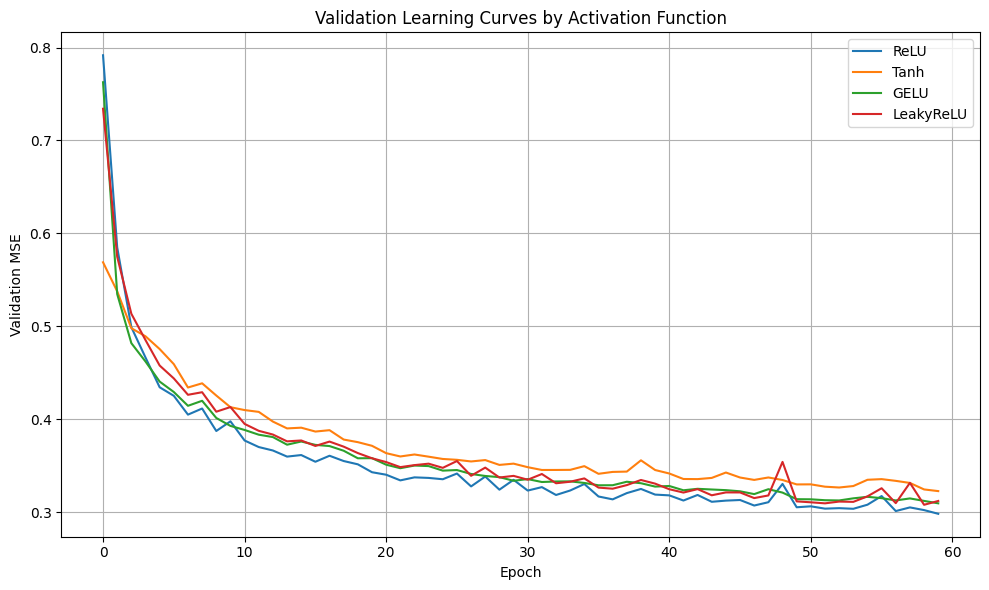

In [ ]:
# ============================================================
# Learning Curves grouped by Activation Function
# ============================================================

plt.figure(figsize=(10, 6))

for act in activations:
    train_curves = [r["train_curve"] for r in results if r["activation"] == act]
    val_curves   = [r["val_curve"] for r in results if r["activation"] == act]

    avg_train = average_curves(train_curves)
    avg_val   = average_curves(val_curves)

    plt.plot(avg_val, label=f"{act}")

plt.xlabel("Epoch")
plt.ylabel("Validation MSE")
plt.title("Validation Learning Curves by Activation Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


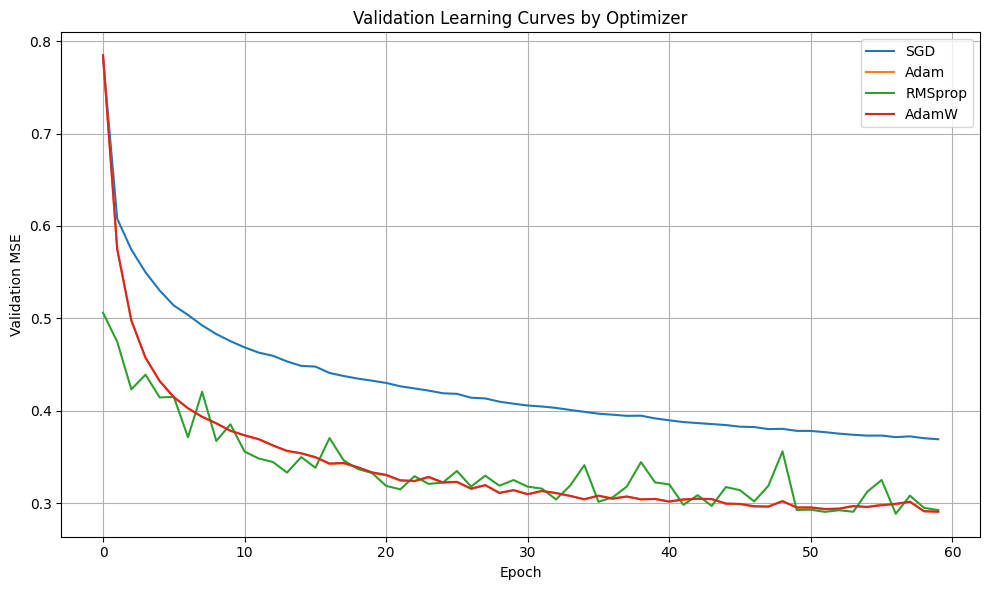

In [ ]:
# ============================================================
# Learning Curves grouped by Optimizer
# ============================================================

plt.figure(figsize=(10, 6))

for opt in optimizers:
    train_curves = [r["train_curve"] for r in results if r["optimizer"] == opt]
    val_curves   = [r["val_curve"] for r in results if r["optimizer"] == opt]

    avg_train = average_curves(train_curves)
    avg_val   = average_curves(val_curves)

    plt.plot(avg_val, label=f"{opt}")

plt.xlabel("Epoch")
plt.ylabel("Validation MSE")
plt.title("Validation Learning Curves by Optimizer")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
